# Learning with a single neuron using Flux.jl

In this notebook, we'll use `Flux` to create a single neuron and teach it to learn, as we did by hand in notebook 10!

### Read in data and process it

Let's start by reading in our data

In [2]:
using CSV
using TextParse
using DataFrames

applecols, applecolnames = TextParse.csvread("data/Apple_Golden_1.dat", '\t')
bananacols, bananacolnames = TextParse.csvread("data/bananas.dat", '\t')

apples = DataFrame(Dict(strip(name)=>col for (name, col) in zip(applecolnames, applecols)))
bananas = DataFrame(Dict(strip(name)=>col for (name, col) in zip(bananacolnames, bananacols)));

and processing it to extract information about the red and green coloring in our images:

In [3]:
col1 = :red
col2 = :green

x_apples  = [ [apples[i, col1], apples[i, col2]] for i in 1:size(apples)[1] ]
x_bananas = [ [bananas[i, col1], bananas[i, col2]] for i in 1:size(bananas)[1] ]

xs = vcat(x_apples, x_bananas)

ys = vcat( zeros(size(x_apples)[1]), ones(size(x_bananas)[1]) );

The input data is in `xs` and the labels (true classifications as bananas or apples) in `ys`.

### Using `Flux.jl`

Now we can load `Flux` to really get going!

In [4]:
using Flux

We saw in the last notebook that σ is a built-in function in `Flux`.

Another function that is used a lot in neural networks is called `ReLU`; in Julia, the function is called `relu`.

#### Exercise 1

Use the docs to discover what `ReLU` is all about.

`relu.([-3, 3])` returns

A) [-3, 3] <br>
B) [0, 3] <br>
C) [0, 0] <br>
D) [3, 3] <br>

#### Solution


If you run

```julia
?relu
```

you'll see that `relu` returns `0` for nonpositive input values and the input value itself for positive input values. Therefore `relu.([-3, 3])` will return (B) `[0, 3]`.

### Making a single neuron in Flux

Let's use `Flux` to build our neuron with 2 inputs and 1 output:

 <img src="data/single-neuron.png" alt="Drawing" style="width: 500px;"/>

We previously put the two weights in a vector, $\mathbf{w}$. Flux instead puts weights in a $1 \times 2$ matrix (i.e. a matrix with 1 *row* and 2 *columns*). 

Previously, to compute the dot product of $\mathbf{w}$ and $\mathbf{x}$ we had to use either the `dot` function, or we had to transpose the vector $\mathbf{w}$:

```julia
# transpose w
b = w' * x
# or use dot!
b = dot(w, x)
```
If the weights are instead stored in a $1 \times 2$ matrix, `W`, then we can simply multiply `W` and `x` together instead!

We start off with random values for our parameters and data:

In [5]:
W = rand(1, 2)

1×2 Array{Float64,2}:
 0.18161  0.994998

In [6]:
x = rand(2)

2-element Array{Float64,1}:
 0.406074
 0.906807

Note that the product of `W` and `x` will now be an array (vector) with a single element, rather than a single number:

In [7]:
W * x

1-element Array{Float64,1}:
 0.976018

This means that our bias `b` is treated as an array when we're using `Flux`:

In [8]:
b = rand(1)

1-element Array{Float64,1}:
 0.900934

#### Exercise 2

Write a function `mypredict` that will take a single input, array `x` and use `W`, `b`, and built-in `σ` to generate an output prediction (stored as an array). This function defines our neural network!

Hint: This function will look very similar to $f_{\mathbf{w},\mathbf{b}}$ from the last notebook but has changed since our data structures to store our parameters have changed!

#### Solution


```julia
mypredict(x) = σ.(W*x + b)
```

**Test**

```julia
W = rand(1, 2)
x = rand(2)
b = rand(1)

isapprox(mypredict(x), σ.(W*x + b))
```

#### Exercise 3

Define a loss function called `loss`.

`loss` should take two inputs: a vector storing data, `x`, and a vector storing the correct "labels" for that data. `loss` should return the sum of the squares of differences between the predictions and the correct labels.

#### Solution


```julia
loss(x, y) = sum((mypredict(x) .- y).^2)
```

**Tests**


```julia
x, y = rand(2), rand(1) 
isapprox( loss(x, y), sum((mypredict(x) .- y).^2) )
```

## Calculating gradients using Flux: backpropagation

For learning, we know that what we need is a way to calculate derivatives of the `loss` function with respect to the parameters `W` and `b`. So far, we have been doing that using finite differences. 

`Flux.jl` instead implements a numerical method called **backpropagation** that calculates gradients (essentially) exactly, in an automatic way, by indirectly applying the rules of calculus.
To do so, it provides a new type of object called "tracked" arrays. These are arrays that store not only their current value, but also information about gradients, which is used by the backpropagation method.

[If you want to understand the maths behind backpropagation, we recommend e.g. [this lecture](https://www.youtube.com/watch?v=i94OvYb6noo).]

To do so, `Flux` provides a function `param` to define such objects that will contain the information for a *param*eter.

Let's start, as usual, by setting up some random initial values for the parameters:

In [9]:
W_data = rand(1, 2)  
b_data = rand(1)

W_data, b_data

([0.402876 0.258938], [0.0206636])

We now set up `Flux.jl` objects that will contain these values *and* their derivatives, and allow to propagate
this information around:

In [10]:
W = param(W_data)
b = param(b_data)

Tracked 1-element Array{Float64,1}:
 0.0206636

Here, `param` is a function that `Flux` provides to create an object that represents a parameter of a machine learning model, i.e. an object which has both a value and derivative information, and such that other objects know how to *keep track* of when it is used in an expression.

#### Exercise 4

What type does `W` have?

A) Array (1D) <br>
B) Array (2D) <br>
C) TrackedArray (1D) <br>
D) TrackedArray (2D) <br>
E) Parameter (1D) <br>
F) Parameter (2D) <br>

#### Solution

D) `TrackedArray` (2D)

```julia
typeof(W)
```
gives `TrackedArray{…,Array{Float64,2}}`. This can be interpreted as `TrackedArray{…,Array{T,N}}` where `T` is the type and `N` is the dimension.

#### Exercise 5

`W` stores not only its current value, but also has space to store gradient information. You can access the values and gradient of the weights as follows:

```julia
W.data
W.grad
```

At this point, are the values of the weights or the gradient of the weights larger?

A) the values of the weights <br>
B) the gradient of the weights

#### Solution

A) the values of the weights.

We've randomly initialized the data in `W` with values between `0` and `1`. When we use `params` to create a `TrackedArray`, the gradient is initialized to `0`.

#### Exercise 6

For data `x` and `y` where

```julia
x, y = [0.413759, 0.692204], [0.845677]
```
apply the loss function to `x` and `y` to give a new variable `l`. What is the type of `l`? (How many dimensions does it have?)

A) Array (0D) <br>
B) Array (1D) <br>
C) TrackedArray (0D) <br>
D) TrackedArray (1D)<br> 
E) Float64<br>
F) Int64<br>

#### Solution

C) `TrackedArray` (0D) (Note that this means that `l` is just a single number!)

```julia
mypredict(x) = σ.(W*x + b)
loss(x, y) = sum((mypredict(x) .- y).^2)
x, y = [0.413759, 0.692204], [0.845677]
l = loss(x, y)
typeof(l)
```

Having set up the structure, we can now **propagate information about derivatives backwards ** from the `loss` function to all of the objects that are used to calculate it:

In [ ]:
using Flux.Tracker

back!(l)   # backpropagate derivatives of the loss function

and now we can look at the derivatives again:

In [ ]:
W.grad

In [ ]:
b.grad

What are these results? They are the components of the **gradient of the loss function** with respect to each component of the object `W`, and with respect to `b`! So as promised, `Flux` has done the hard work of calculating derivatives for us!

*Bonus info*:

To do so, internally Flux sets up a "computational graph" and propagates the information on derivatives backwards through the graph. Each node of the graph knows which objects feed into that node, so it tells them to also update their gradients, etc.

### Stochastic gradient descent

We can now use these features to reimplement stochastic gradient descent, following the method we used in the previous notebook, but now using backpropagation!

#### Exercise 7

Modify the code from the previous notebook for stochastic gradient descent to use Flux instead.

#### Solution

In [11]:
mypredict(x) = σ.(W*x + b)
loss(x, y) = sum((mypredict(x) .- y).^2)

loss (generic function with 1 method)

In [12]:
x, y = [0.413759, 0.692204], [0.845677]
loss(x, y)

0.06504588893722459 (tracked)

In [13]:
function stochastic_gradient_descent(loss, W, b, xs, ys, N=1000)

    η = 0.01
    
    for step in 1:N

        i = rand(1:length(xs))  # choose a data point

        x = xs[i]
        y = ys[i]

        l = loss(x, y)
        back!(l)

        b.data -= η * b.grad
        W.data -= η * W.grad
    end
    
    return W, b
    
end

stochastic_gradient_descent (generic function with 2 methods)

### Investigating stochastic gradient descent

Let's look at the values stored in `b` before we run stochastic gradient descent:

In [14]:
b

Tracked 1-element Array{Float64,1}:
 0.0206636

After running `stochastic_gradient_descent`, we find the following:

In [15]:
W_final, b_final = stochastic_gradient_descent(loss, W, b, xs, ys, 100000)

LoadError: [91mUndefVarError: back! not defined[39m

we can look at the values of `W_final` and `b_final`, which our machine learned to generate our desired classification.

In [16]:
W_final

LoadError: [91mUndefVarError: W_final not defined[39m

In [17]:
b_final

LoadError: [91mUndefVarError: b_final not defined[39m

#### Exercise 8

Plot the data and the learned function.

#### Solution

In [18]:
using Plots; gr()

Plots.GRBackend()

Let's draw the function that the network has learned, together with the data:

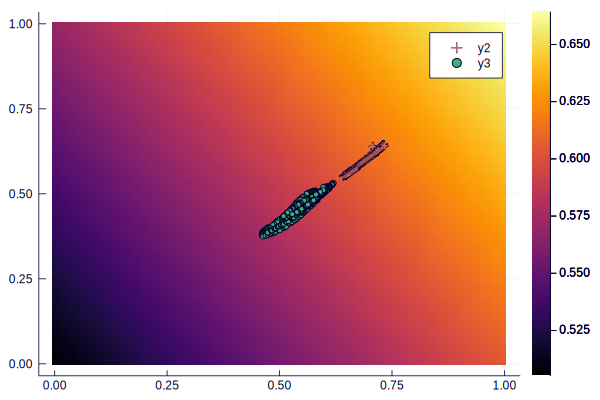

In [19]:
heatmap(0:0.01:1, 0:0.01:1, (x,y)->mypredict([x, y]).data[1])

scatter!(first.(x_apples), last.(x_apples), m=:cross)
scatter!(first.(x_bananas), last.(x_bananas))

#### Exercise 9

Do this plot every so often as the learning process is proceeding in order to have an animation of the process.

### Automation with Flux.jl

We will need to repeat the above process for a lot of different systems.
Fortunately, `Flux.jl` provides us with tools to automate this!

Flux allows to create a neuron in a simple way:

In [2]:
using Flux

In [3]:
model = Dense(2, 1, σ)

Dense(2, 1, NNlib.σ)

The `2` and `1` refer to the number of inputs and outputs, and the neuron is defined using the $\sigma$ function.

In [4]:
typeof(model)

Flux.Dense{NNlib.#σ,TrackedArray{…,Array{Float64,2}},TrackedArray{…,Array{Float64,1}}}

We have made an object of type `Dense`, defined by `Flux`, with the name `model`. This represents a "dense neural network layer" (see later for more on neural network layers).
The parameters that will be modified during the learning process live *inside* the `model` object.

#### Exercise 10

Investigate which variables live inside the `model` object and what type they are. How does that compare to the call to create the `Dense` object that we started with?

#### Solution

Use `model.<TAB>` (i.e. write `model.` and then press the `TAB` key to do autocompletion) to check interactively what is inside the `model` object, or

In [5]:
fieldnames(model)

3-element Array{Symbol,1}:
 :W
 :b
 :σ

In [6]:
model.W

Tracked 1×2 Array{Float64,2}:
 -0.0630837  -0.756457

In [7]:
model.b

Tracked 1-element Array{Float64,1}:
 0.0

The fact that `model.W` and `model.b` are of size $1 \times 2$ and $1$, respectively, comes from the `(2, 1)` pair in the call to the `Dense` constructor when we created `model`.

`model.W` will be multiplied by a vector `x` of length 2, which it is why it needs to be of size $1 \times 2$.

Again, these are tracked arrays so that Flux can calculate their gradients.

### Model object as a function

We can apply the `model` object to data just as if it were a standard function:

In [25]:
model(rand(2))

Tracked 1-element Array{Float64,1}:
 0.321367

#### Exercise 11

Prove to yourself that you understand what is going on when we call `model`. Create two arrays `W` and `b` with the same elements as `model.W` and `model.b`. Use `W` and `b` to generate the same answer that you get when we call `model([.5, .5])`.

### Using Flux

We now need to provide Flux with three pieces of information: 

1. A loss function
2. Some training data
3. An optimization method

### Loss functions

Flux has various loss functions built in, for example the mean-squared error (`mse`) that we have been using:

In [ ]:
loss(x, y) = Flux.mse(model(x), y)

Another common one is the cross entropy, `Flux.crossentropy`.

### Data

The data can take a couple of different forms. 
One form is a single **iterator**, consisting of pairs $(x, y)$ of data and labels.
We can achieve this with `zip`.

#### Exercise 12

Use `zip` to "zip together" `xs` and `ys`. Then use the `collect` function to check what `zip` actually does.

#### Solution

In [8]:
data = zip(xs, ys)

LoadError: [91mUndefVarError: xs not defined[39m

In [ ]:
collect(data)

### Optimization routine

Now we need to tell Flux what kind of optimization routine to use. It has several built in; the standard stochastic gradient descent algorithm that we have been using is called `SGD`. We must pass it two things: a list of parameter objects which will be modified by the optimization routine, and a step size:

In [ ]:
opt = SGD([model.W, model.b], 0.01)
# give a list of the parameters that will be modified

The gradient calculations and parameter updates will be carried out by this optimizer function; we do not see those details, but if you are curious, you can, of course, look at the `Flux.jl` source code!

### Training

We now have all the pieces in place to actually **train** our model (a single neuron) on the data. 
"Training" refers to using pre-labeled data to learn the function that relates the input data to the desired output data given by the labels.

`Flux` provides the function `train!`, which performs a single pass through the data and does a single step of optimization using the partial cost function for each data point:

In [ ]:
Flux.train!(loss, data, opt)

We can then just repeat this several times to train the network more and coax it towards the minimum of the cost function:

In [ ]:
for i in 1:100
    Flux.train!(loss, data, opt)
end

Now let's look at the parameters after training:

In [ ]:
model.W

In [ ]:
model.b

Instead of writing out a list of parameters to modify, `Flux` provides the function `params`, which extracts all available parameters from a model:

In [ ]:
opt = SGD(params(model), 0.01)

In [ ]:
params(model)

## Adding more features

#### Exercise 13

So far we have just used two features, red and green. 

(i) Add a third feature, blue. Plot the new data.

(ii) Train a neuron with 3 inputs and 1 output on the data.

(iii) Can you find a good way to visualize the result?